# Preprocessing and experiment overview

Content:
1. Generate synthetic data
2. Experiment overview
3. Cleaning up error files
4. Profiling

In [11]:
# preamble
import os
import numpy as np
from data_processors import generate_syndata
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## 1) Generate synthetic data

Synthetic data experiments:
- different number of nodes in cluster: balanced or unbalanced cluster size
- number of clusters K: few, "medium", many
- number of graph types (class imbalance): S1=S2 and S1>S2

we fix the number of nodes N = 100 and then adjust Nc wrt. K

Suggestion:
N = 100

K = 2, 5, 10, (20)

if balanced partition:

    Nc = N/K (balanced partition: all clusters have same size)

else: unbalanced partition

    Nc = (70, 30), (60, 20, 10, 5, 5), (20, 20, 10, 10, 10, 10, 5, 5, 5,5)

Steps:
1. Compute partition: 2 (balanced and unbalanced Nc) x 3 (different K) = 6 types of partitions
2. Compute block/cluster interactions (eta): same eta, completely different eta or partially different eta
3. Construct adjacency matrices

Using partially different etas


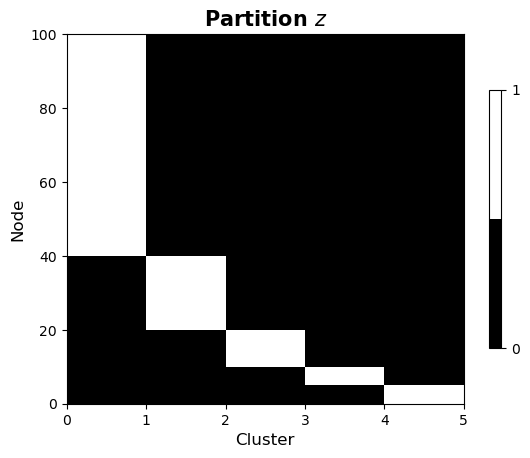

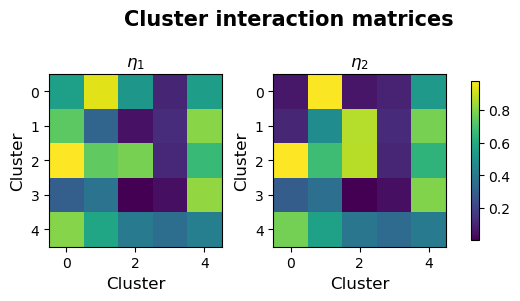

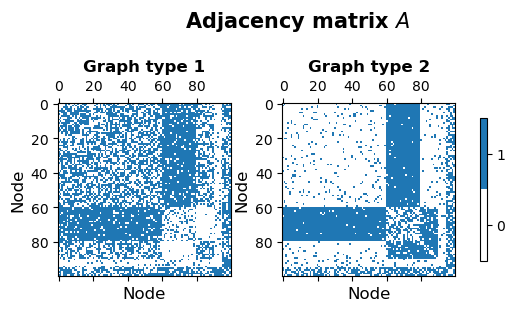

In [7]:
A, z, eta1, eta2 = generate_syndata(N=100, K=5, S1=5, S2=5, 
                                    balance_Nc=False, 
                                    eta_similarity='partial_different', 
                                    seed=0, disp_data=True)

In [6]:
N = 100
S2 = 5
K_list= [2, 5, 10]
S1_list = [5, 10]
balance_Nc_list = [True, False]
eta_similarity_list = ['same', 'comp_diff', 'part_diff']
for K in K_list:
    for S1 in S1_list:
        for balance_Nc in balance_Nc_list:
            for eta_similarity in eta_similarity_list:
                A, _, _, _ = generate_syndata(N, K, S1, S2, balance_Nc, eta_similarity, seed=0, disp_data=False)
                filename = 'A_'+str(N)+'_'+str(K)+'_'+str(S1)+'_'+str(S2)+'_'+str(balance_Nc)+'_'+str(eta_similarity)+'.npy'
                np.save(os.path.join('/work3/s174162/speciale/data/synthetic/', filename), A)

In [14]:
A = np.load('/work3/s174162/speciale/data/synthetic/A_100_10_10_5_False_part_diff.npy', allow_pickle=True)

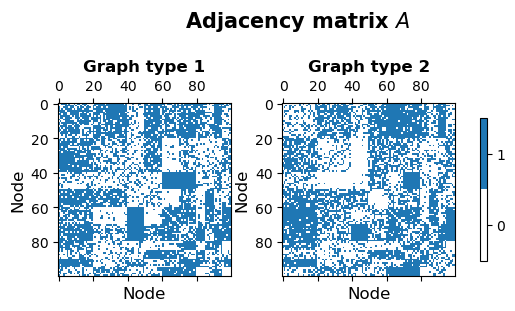

In [15]:
default_blue = '#1f77b4'
cmap_binary = ListedColormap(['white', default_blue]) 
fig, ax = plt.subplots(1,2)
plt.subplots_adjust(wspace=0.3, top=1.1)
im = ax[0].spy(A[:,:,0],cmap=cmap_binary)
ax[0].set_ylabel('Node', fontsize=12)
ax[0].set_xlabel('Node', fontsize=12)
ax[0].set_title('Graph type 1', weight='bold')
im = ax[1].spy(A[:,:,-1],cmap=cmap_binary)
ax[1].set_ylabel('Node', fontsize=12)
ax[1].set_xlabel('Node', fontsize=12)
ax[1].set_title('Graph type 2', weight='bold')
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.3)
fig.suptitle('Adjacency matrix $A$',fontsize=15, weight='bold')
plt.show()

In [16]:
A.shape

(100, 100, 15)

## 2) Experiment overview

In [39]:
# Define the top-level directory containing the log files
top_dir = 'results'

# Create an empty list to store the data from each log file
data = []

# Recursively iterate over all log files in the directory structure
for root, dirs, files in os.walk(top_dir):
    for file_name in files:
        if file_name == 'log.txt':
            # Read the contents of the file
            with open(os.path.join(root, file_name), 'r') as f:
                file_data = f.readlines()
            
            # Parse the data from the file and add it to the list
            file_dict = {}
            for line in file_data:
                key, value = line.strip().split(': ')
                # Try to convert the value to a number
                try:
                    value = float(value)
                    # Check if the value is an integer and convert it if it is
                    if value.is_integer():
                        value = int(value)
                except ValueError:
                    pass
                file_dict[key] = value
            data.append(file_dict)

# Convert the list of dictionaries to a Pandas DataFrame
df = pd.DataFrame(data)
df = df.fillna('None')


In [40]:
# delete random test runs
df.loc[df.maxiter_gibbs < 100]

,dataset,exp_name,atlas_name,n_rois,threshold_annealing,model_type,splitmerge,noc,maxiter_gibbs,maxiter_eta0,maxiter_alpha,matlab_compare,N,K,S1,S2,balance_Nc,eta_similarity


In [36]:
import shutil

df_folders_to_delete = df.loc[df.
                              maxiter_gibbs < 100,['dataset','exp_name']]
df_folders_to_delete['folder'] = df_folders_to_delete.dataset + '/' + df_folders_to_delete.exp_name
for folder in df_folders_to_delete.folder:
    # Use shutil.rmtree to recursively delete the folder and its contents
    shutil.rmtree('results/'+folder)

In [41]:
# count experiment initializations
config_names = df.columns.tolist()
config_names.remove('exp_name')
duplicated_rows = df.duplicated(subset=config_names)
unique_rows = df[~duplicated_rows].copy()
duplicate_count = df.groupby(config_names, as_index=False)['exp_name'].agg(list)
duplicate_count['n_exp'] = duplicate_count['exp_name'].apply(len)
df_new = unique_rows.merge(duplicate_count, on=config_names, how='left')
df_new = df_new.drop('exp_name_x', axis=1)
df_new = df_new.rename(columns={'exp_name_y': 'exp_name_list'})

In [42]:
df_new

,dataset,atlas_name,n_rois,threshold_annealing,model_type,splitmerge,noc,maxiter_gibbs,maxiter_eta0,maxiter_alpha,matlab_compare,N,K,S1,S2,balance_Nc,eta_similarity,exp_name_list,n_exp
0,hcp,schaefer,100.0,False,parametric,False,10,1000,10,100,None,None,None,None,None,None,None,[parametric_schaefer100_2023-05-10 14:59:03.98...,10
1,hcp,schaefer,100.0,False,parametric,False,20,1000,10,100,None,None,None,None,None,None,None,[parametric_schaefer100_2023-05-09 20:52:42.64...,10
2,hcp,schaefer,200.0,False,parametric,False,50,1000,10,100,None,None,None,None,None,None,None,[parametric_schaefer200_2023-05-10 12:32:50.65...,10
3,hcp,schaefer,300.0,False,parametric,False,40,1000,10,100,None,None,None,None,None,None,None,[parametric_schaefer300_2023-05-10 10:24:56.75...,10
4,hcp,schaefer,100.0,False,parametric,False,50,1000,10,100,None,None,None,None,None,None,None,[parametric_schaefer100_2023-05-10 04:48:52.29...,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,synthetic,None,None,None,nonparametric,True,10,100,10,100,False,100.0,2.0,10.0,5.0,True,part_diff,[nonparametric_2_10_5_True_part_diff2023-05-22...,20
172,synthetic,None,None,None,parametric,False,10,100,10,100,False,100.0,5.0,10.0,5.0,True,same,[parametric_5_10_5_True_same2023-05-22 13:17:4...,20
173,synthetic,None,None,None,parametric,False,5,100,10,100,False,100.0,5.0,5.0,5.0,True,comp_diff,[parametric_5_5_5_True_comp_diff2023-05-22 13:...,20
174,synthetic,None,None,None,nonparametric,True,2,100,10,100,False,100.0,2.0,5.0,5.0,True,same,[nonparametric_2_5_5_True_same2023-05-22 13:36...,20


In [44]:
# sort by hcp
df_new.loc[df_new.dataset=='hcp'].sort_values(by=['n_rois','threshold_annealing','model_type','splitmerge','noc'], ascending=True)

,dataset,atlas_name,n_rois,threshold_annealing,model_type,splitmerge,noc,maxiter_gibbs,maxiter_eta0,maxiter_alpha,matlab_compare,N,K,S1,S2,balance_Nc,eta_similarity,exp_name_list,n_exp
0,hcp,schaefer,100.0,False,parametric,False,10,1000,10,100,None,None,None,None,None,None,None,[parametric_schaefer100_2023-05-10 14:59:03.98...,10
1,hcp,schaefer,100.0,False,parametric,False,20,1000,10,100,None,None,None,None,None,None,None,[parametric_schaefer100_2023-05-09 20:52:42.64...,10
12,hcp,schaefer,100.0,False,parametric,False,30,1000,10,100,None,None,None,None,None,None,None,[parametric_schaefer100_2023-05-09 21:28:47.73...,10
15,hcp,schaefer,100.0,False,parametric,False,40,1000,10,100,None,None,None,None,None,None,None,[parametric_schaefer100_2023-05-10 09:41:13.54...,10
4,hcp,schaefer,100.0,False,parametric,False,50,1000,10,100,None,None,None,None,None,None,None,[parametric_schaefer100_2023-05-10 04:48:52.29...,10
13,hcp,schaefer,100.0,True,nonparametric,True,30,400,10,100,None,None,None,None,None,None,None,[nonparametric_schaefer100_2023-05-10 20:45:53...,20
9,hcp,schaefer,200.0,False,parametric,False,10,1000,10,100,None,None,None,None,None,None,None,[parametric_schaefer200_2023-05-10 07:17:44.76...,10
8,hcp,schaefer,200.0,False,parametric,False,20,1000,10,100,None,None,None,None,None,None,None,[parametric_schaefer200_2023-05-09 20:52:42.65...,10
14,hcp,schaefer,200.0,False,parametric,False,30,1000,10,100,None,None,None,None,None,None,None,[parametric_schaefer200_2023-05-10 15:17:54.65...,10
5,hcp,schaefer,200.0,False,parametric,False,40,1000,10,100,None,None,None,None,None,None,None,[parametric_schaefer200_2023-05-10 18:03:23.92...,10


In [16]:
# get list of experiment names for desired experiment
df_new.iloc[13].exp_name_list

['nonparametric_schaefer100_2023-05-10 20:45:53.754002',
 'nonparametric_schaefer100_2023-05-10 20:21:08.776971',
 'nonparametric_schaefer100_2023-05-10 23:59:33.523289',
 'nonparametric_schaefer100_2023-05-10 21:16:56.678833',
 'nonparametric_schaefer100_2023-05-11 18:11:41.649321',
 'nonparametric_schaefer100_2023-05-12 15:12:42.756157',
 'nonparametric_schaefer100_2023-05-11 00:14:21.861380',
 'nonparametric_schaefer100_2023-05-12 17:19:22.406275',
 'nonparametric_schaefer100_2023-05-10 19:41:28.367649',
 'nonparametric_schaefer100_2023-05-12 20:26:39.236390',
 'nonparametric_schaefer100_2023-05-11 17:07:21.545262',
 'nonparametric_schaefer100_2023-05-11 16:04:22.729430',
 'nonparametric_schaefer100_2023-05-10 22:02:25.003527',
 'nonparametric_schaefer100_2023-05-11 20:36:00.936739',
 'nonparametric_schaefer100_2023-05-11 20:21:43.681390',
 'nonparametric_schaefer100_2023-05-12 20:30:57.303624',
 'nonparametric_schaefer100_2023-05-11 18:47:57.296448',
 'nonparametric_schaefer100_202

In [45]:
# sort by hcp
df_new.loc[df_new.dataset=='decnef'].sort_values(by=['n_rois','threshold_annealing','model_type','splitmerge','noc'], ascending=True)

,dataset,atlas_name,n_rois,threshold_annealing,model_type,splitmerge,noc,maxiter_gibbs,maxiter_eta0,maxiter_alpha,matlab_compare,N,K,S1,S2,balance_Nc,eta_similarity,exp_name_list,n_exp
19,decnef,schaefer,100.0,False,parametric,False,10,1000,10,100,None,None,None,None,None,None,None,[parametric_schaefer100_2023-05-09 22:01:39.18...,10
31,decnef,schaefer,100.0,False,parametric,False,20,1000,10,100,None,None,None,None,None,None,None,[parametric_schaefer100_2023-05-10 12:58:16.02...,10
22,decnef,schaefer,100.0,False,parametric,False,30,1000,10,100,None,None,None,None,None,None,None,[parametric_schaefer100_2023-05-10 10:43:10.52...,10
17,decnef,schaefer,100.0,False,parametric,False,40,1000,10,100,None,None,None,None,None,None,None,[parametric_schaefer100_2023-05-10 15:52:11.35...,10
16,decnef,schaefer,100.0,False,parametric,False,50,1000,10,100,None,None,None,None,None,None,None,[parametric_schaefer100_2023-05-10 00:46:31.11...,10
21,decnef,schaefer,100.0,True,nonparametric,True,30,400,10,100,None,None,None,None,None,None,None,[nonparametric_schaefer100_2023-05-11 17:39:16...,20
18,decnef,schaefer,200.0,False,parametric,False,10,1000,10,100,None,None,None,None,None,None,None,[parametric_schaefer200_2023-05-09 22:30:50.47...,10
30,decnef,schaefer,200.0,False,parametric,False,20,1000,10,100,None,None,None,None,None,None,None,[parametric_schaefer200_2023-05-10 03:36:25.45...,10
23,decnef,schaefer,200.0,False,parametric,False,30,1000,10,100,None,None,None,None,None,None,None,[parametric_schaefer200_2023-05-10 11:09:30.49...,10
29,decnef,schaefer,200.0,False,parametric,False,40,1000,10,100,None,None,None,None,None,None,None,[parametric_schaefer200_2023-05-10 16:15:44.63...,10


In [46]:
df_new.loc[df_new.dataset=='synthetic'].sort_values(by=['N','K','S1','S2','balance_Nc', 'eta_similarity', 'model_type','splitmerge','noc'], ascending=True)

,dataset,atlas_name,n_rois,threshold_annealing,model_type,splitmerge,noc,maxiter_gibbs,maxiter_eta0,maxiter_alpha,matlab_compare,N,K,S1,S2,balance_Nc,eta_similarity,exp_name_list,n_exp
100,synthetic,None,None,None,nonparametric,True,2,100,10,100,False,100.0,2.0,5.0,5.0,True,comp_diff,[nonparametric_2_5_5_True_comp_diff2023-05-22 ...,20
78,synthetic,None,None,None,nonparametric,True,5,100,10,100,False,100.0,2.0,5.0,5.0,True,comp_diff,[nonparametric_2_5_5_True_comp_diff2023-05-22 ...,20
88,synthetic,None,None,None,nonparametric,True,10,100,10,100,False,100.0,2.0,5.0,5.0,True,comp_diff,[nonparametric_2_5_5_True_comp_diff2023-05-22 ...,20
76,synthetic,None,None,None,nonparametric,True,20,100,10,100,False,100.0,2.0,5.0,5.0,True,comp_diff,[nonparametric_2_5_5_True_comp_diff2023-05-22 ...,20
62,synthetic,None,None,None,parametric,False,2,100,10,100,False,100.0,2.0,5.0,5.0,True,comp_diff,[parametric_2_5_5_True_comp_diff2023-05-22 13:...,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,synthetic,None,None,None,nonparametric,True,20,100,10,100,False,100.0,10.0,10.0,5.0,True,same,[nonparametric_10_10_5_True_same2023-05-22 13:...,20
96,synthetic,None,None,None,parametric,False,2,100,10,100,False,100.0,10.0,10.0,5.0,True,same,[parametric_10_10_5_True_same2023-05-22 13:53:...,20
125,synthetic,None,None,None,parametric,False,5,100,10,100,False,100.0,10.0,10.0,5.0,True,same,[parametric_10_10_5_True_same2023-05-22 13:35:...,20
161,synthetic,None,None,None,parametric,False,10,100,10,100,False,100.0,10.0,10.0,5.0,True,same,[parametric_10_10_5_True_same2023-05-22 13:09:...,20


## 3) Clean up error files that was interrupted

In [19]:
# Cleaning up output and error files for experiments
# define the directory to search for .txt files
directory = os.getcwd()

# define the word to search for
word_to_find = "KeyboardInterrupt"

# loop over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        # open the file and read its contents
        with open(os.path.join(directory, filename), "r") as file:
            file_contents = file.read()
            
        # check if the word is in the file contents
        if word_to_find in file_contents:
            # delete the file
            os.remove(os.path.join(directory, filename)) # deleting error file 
            output_filename = 'out_'+filename.split('err_')[1]
            os.remove(os.path.join(directoy, output_filename)) # deleting corresponding output file
            print(f"File {filename} deleted.")
            print(f"File {output_filename} deleted.")

In [50]:
# removing hpc output files
def remove_files_with_keyword(directory, keyword):
    for filename in os.listdir(directory):
        if keyword in filename:
            filepath = os.path.join(directory, filename)
            os.remove(filepath)

# Specify the directory where the files are located
directory = '/work3/s174162/speciale'

# Remove files containing "out_big"
remove_files_with_keyword(directory, "out_big")

# Remove files containing "err_big"
remove_files_with_keyword(directory, "err_big")

## 4) Profiling

In [20]:
import cProfile
import numpy as np
import pstats
import argparse
from model import MultinomialSBM

In [ ]:
Z = np.load('Z.npy')
JJ = np.load('JJ.npy')
#Force = np.load('Force.npy')
logP_A = np.load('logP_A.npy')
logP_Z = np.load('logP_Z.npy')

In [ ]:
config = argparse.Namespace(dataset='hcp', Nc=50, K=5, S1=5, S2=5, atlas_name='schaefer', n_rois=100, threshold_annealing=False, model_type='nonparametric', noc=50, splitmerge=True, maxiter_gibbs=1, maxiter_eta0=10, maxiter_alpha=100, maxiter_splitmerge=10, unit_test=False, matlab_compare=False, main_dir='/work3/s174162/speciale/', disp=True, sample_step=10)
model = MultinomialSBM(config)
Z, logP_A, logP_Z, _, _= model.gibbs_sample_Z(Z, JJ, comp=[], Force=[])